The input needed for this code is review data in the form of dictionary which was produced using the "Data Pull" script

In [1]:
file_name='final.p'

In [2]:
import pickle
loaded_df=pickle.load(open(file_name,"rb"))

In [3]:
len(loaded_df)

617534

In [4]:
loaded_df.describe()

,comment_count,timestamp_created,timestamp_updated,votes_funny,votes_up,timestamp_dev_responded
count,617534.000000,6.175340e+05,6.175340e+05,6.175340e+05,617534.000000,8944.0
mean,0.573424,1.487518e+09,1.489373e+09,3.755740e+05,12.919566,0.0
std,3.058338,5.239578e+07,5.130556e+07,4.016129e+07,48.309488,0.0
min,0.000000,1.287234e+09,1.287370e+09,0.000000e+00,0.000000,0.0
25%,0.000000,1.452451e+09,1.454468e+09,0.000000e+00,1.000000,0.0
50%,0.000000,1.487777e+09,1.488609e+09,0.000000e+00,4.000000,0.0
75%,0.000000,1.527279e+09,1.529301e+09,1.000000e+00,10.000000,0.0
max,1285.000000,1.568305e+09,1.568305e+09,4.294967e+09,7217.000000,0.0


In [5]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617534 entries, 0 to 617533
Data columns (total 17 columns):
author                         617534 non-null object
comment_count                  617534 non-null int64
language                       617534 non-null object
received_for_free              617534 non-null bool
recommendationid               617534 non-null object
review                         617534 non-null object
steam_purchase                 617534 non-null bool
timestamp_created              617534 non-null int64
timestamp_updated              617534 non-null int64
voted_up                       617534 non-null bool
votes_funny                    617534 non-null int64
votes_up                       617534 non-null int64
weighted_vote_score            617534 non-null object
written_during_early_access    617534 non-null bool
game_name                      617534 non-null object
developer_response             8944 non-null object
timestamp_dev_responded        8944 non-

Check for duplicates and missing review content data

In [6]:
loaded_df.columns

Index(['author', 'comment_count', 'language', 'received_for_free',
       'recommendationid', 'review', 'steam_purchase', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_funny', 'votes_up',
       'weighted_vote_score', 'written_during_early_access', 'game_name',
       'developer_response', 'timestamp_dev_responded'],
      dtype='object')

In [7]:
review_df=loaded_df[['author','review','game_name']]

In [8]:
review_df

,author,review,game_name
0,76561198831801803,dont know how to use soundtrack or comic :/ hi...,Pikuniku Soundtrack + Comic
1,76561198208927921,"Bad game, totally worthless.",Four-color Fantasy
2,76561198831801803,dont know how to use soundtrack or comic :/ hi...,Pikuniku Soundtrack + Comic
3,76561198208927921,"Bad game, totally worthless.",Four-color Fantasy
4,76561198063789203,It's 2:54 AM and I'm crying over winning a dra...,Drag Star!
5,76561198343959533,I literally stayed up til 3 am because I *need...,Drag Star!
6,76561198079874042,"I've never seen Drag Race, so I was a little u...",Drag Star!
7,76561198027028658,Is it STUNNING? Not quite.\n\nIs it a deliriou...,Drag Star!
8,76561198394047586,funny game lol,Hentai balls v3
9,76561198031712524,The voice intro upon the sales page was well d...,Age Of Omens


In [9]:
review_df=review_df.drop_duplicates()
review_df=review_df.dropna()

In [10]:
len(review_df)

214420

In [11]:
import pickle
pickle.dump(review_df,open("cleaned_review.p","wb"))

In [12]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

In [13]:
lang=list()
for num in range(len(review_df['review'])):
    try: 
        detected=detect(review_df['review'][num])
        lang.append(detected)
    except:
        lang.append('NaN')

In [14]:
review_df['detected_lang']=lang
review_df=review_df[review_df['detected_lang']=='en']

In [15]:
from textblob import TextBlob

In [16]:
review_sentiment=list()
review_recomd=list()
i=0
for review in review_df.review:
    sent = TextBlob(review)
    rating=round(2*(sent.sentiment.polarity+1))
    if sent.sentiment.polarity>0:
        recomd=True
    else:
        recomd=False
    review_sentiment.append(rating)
    review_recomd.append(recomd)

In [17]:
review_df['review_sentiment']=review_sentiment
review_df['recommend']=review_recomd

In [18]:
review_df

,author,review,game_name,detected_lang,review_sentiment,recommend
0,76561198831801803,dont know how to use soundtrack or comic :/ hi...,Pikuniku Soundtrack + Comic,en,2,True
1,76561198208927921,"Bad game, totally worthless.",Four-color Fantasy,en,1,False
6,76561198079874042,"I've never seen Drag Race, so I was a little u...",Drag Star!,en,2,True
7,76561198027028658,Is it STUNNING? Not quite.\n\nIs it a deliriou...,Drag Star!,en,2,False
8,76561198394047586,funny game lol,Hentai balls v3,en,2,True
9,76561198031712524,The voice intro upon the sales page was well d...,Age Of Omens,en,2,True
11,76561198008485568,"Ok, I'm aware that the dev has made a lot of w...",Age Of Omens,en,2,False
12,76561197993867041,Normally as Things go I will update my reviews...,Age Of Omens,en,2,True
13,76561198098021346,This game doesn't make much sense. When I firs...,DUST-UP,en,2,True
14,76561198070421597,"Simplistic, Unrealistic, and Unpolished\n\nFir...",Balanced Politics Simulator,en,2,True


In [19]:
good=review_df[review_df['recommend']==True]
bad=review_df[review_df['recommend']==False]

In [20]:
print("There are",len(good),"positive reviews in my data")
print("There are",len(bad),"negative reviews in my data")

There are 51135 positive reviews in my data
There are 28531 negative reviews in my data


                                                    review
game_name                                                 
DayZ                                                    35
Bright Memory                                           33
Celeste                                                 33
My Time At Portia                                       32
Wallpaper Engine                                        31
UnderMine                                               30
Mortal Kombat 11                                        30
BATTLETECH                                              29
Her Story                                               29
Rocket League                                           29
Geometry Dash                                           29
EARTH DEFENSE FORCE 5                                   28
Deathgarden: BLOODHARVEST                               28
GRIS                                                    28
Insurgency: Sandstorm                                   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ca8de4518>]],
      dtype=object)

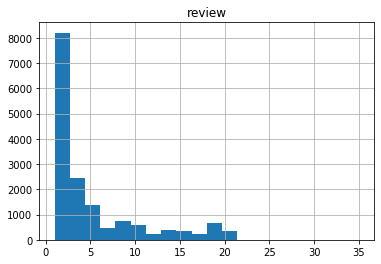

In [32]:
reviewnum=review_df.groupby(['game_name']).agg({'review':'count'})
reviewnum_new=reviewnum.reset_index().sort_values('review',ascending=False).set_index('game_name')
print(reviewnum_new[:100])
reviewnum_new.hist(bins=20)

In [22]:
review_length=[len(review) for review in review_df['review']]

(array([64570.,  8908.,  3114.,  1397.,   720.,   398.,   215.,   136.,
           67.,   141.]),
 array([   0.,  800., 1600., 2400., 3200., 4000., 4800., 5600., 6400.,
        7200., 8000.]),
 <a list of 10 Patch objects>)

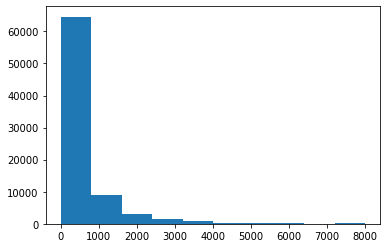

In [25]:
plt.hist(review_length)

                   review
author                   
76561198066590240     206
76561198069159152     144
76561198019816374     120
76561198137285867     117
76561197960373660      97
76561198440309009      94
76561198053422627      75
76561198048974498      66
76561198160868511      59
76561198040884867      53
                   review
author                   
76561198036187141       1
76561198036191595       1
76561198036194590       1
76561198036198270       1
76561198036209052       1
76561198036213213       1
76561198036214828       1
76561198036217554       1
76561198036220129       1
76561198989301174       1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4cbfead8d0>]],
      dtype=object)

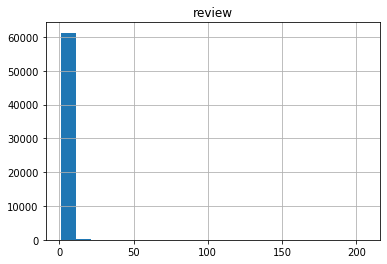

In [16]:
reviewauthor=review_df.groupby(['author']).agg({'review':'count'})
reviewauthor_new=reviewauthor.reset_index().sort_values('review',ascending=False).set_index('author')
reviewauthor_new.describe()
print(reviewauthor_new[0:10])
print(reviewauthor_new[-10:])
#plt.hist(reviewauthor_new)
reviewauthor_new.hist(bins=20)

                   review
game_name                
DayZ                   35
Bright Memory          33
Celeste                33
My Time At Portia      32
Wallpaper Engine       31
UnderMine              30
Mortal Kombat 11       30
BATTLETECH             29
Her Story              29
Rocket League          29
                   review
author                   
76561198036187141       1
76561198036191595       1
76561198036194590       1
76561198036198270       1
76561198036209052       1
76561198036213213       1
76561198036214828       1
76561198036217554       1
76561198036220129       1
76561198989301174       1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4cbfb51940>]],
      dtype=object)

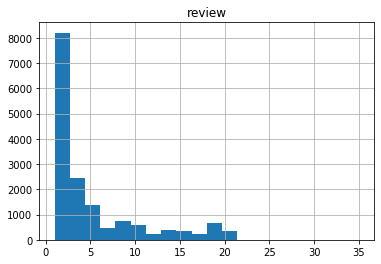

In [17]:
reviewgame=review_df.groupby(['game_name']).agg({'review':'count'})
reviewgame_new=reviewgame.reset_index().sort_values('review',ascending=False).set_index('game_name')
reviewgame_new.describe()
print(reviewgame_new[0:10])
print(reviewgame_new[-10:])
reviewgame_new.hist(bins=20)

In [18]:
import pickle
pickle.dump(review_df,open("cleaned_review_w_language.p","wb"))